In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.nn.functional import mse_loss
from torchvision import transforms, models
from datetime import datetime

torch.manual_seed(124)

In [ ]:
model = models.vgg19(pretrained=True)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# apenas features
model = model.features

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Processamento das imagens

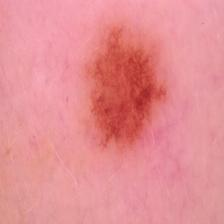

In [ ]:
new_img = Image.open("/content/15.jpg")
new_img

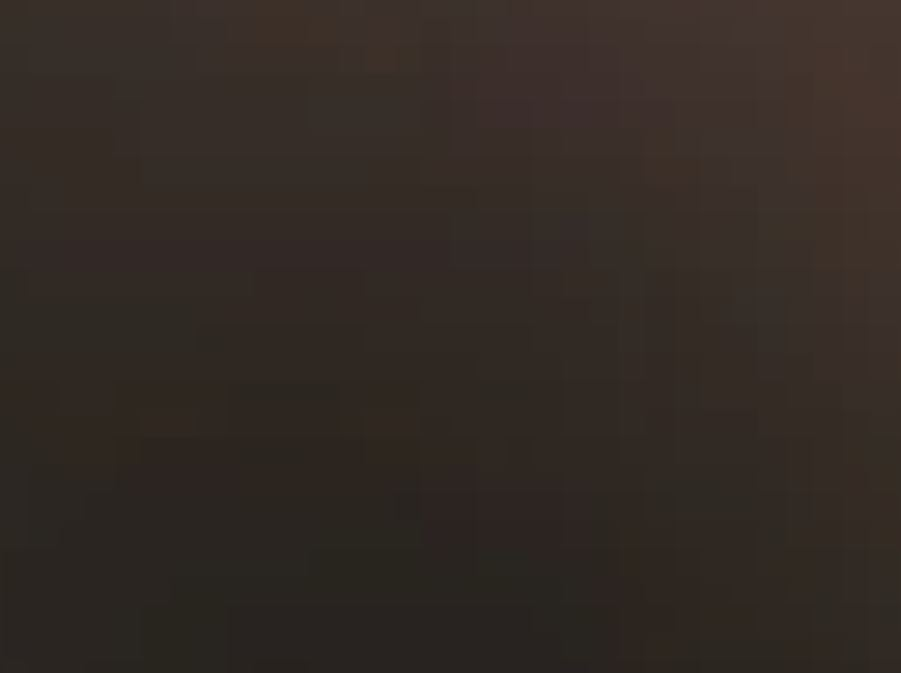

In [ ]:
style_img = Image.open("/content/Capturar(1).JPG")
style_img

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
new_img = transform(new_img)

In [ ]:
new_img.shape

torch.Size([3, 224, 224])

In [ ]:
shape = new_img.shape[1:]
shape

torch.Size([224, 224])

In [ ]:
transform = transforms.Compose([
    transforms.Resize(shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
style_img = transform(style_img)

In [ ]:
style_img.shape

torch.Size([3, 224, 224])

In [ ]:
new_img = new_img.unsqueeze(0) # adicionado uma feature para pt
style_img = style_img.unsqueeze(0)

In [ ]:
new_img.shape, style_img.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [ ]:
def show_img(img):
  img = img.cpu().clone().detach().numpy().squeeze(0)
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  img = img.clip(0, 1)

  return img

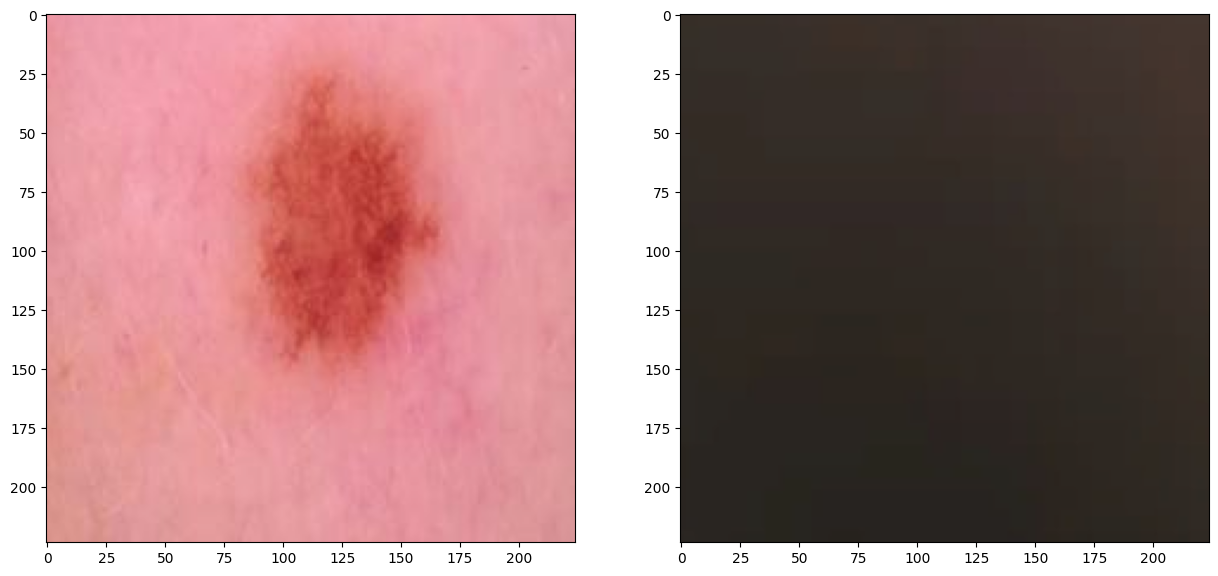

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(show_img(new_img))
ax[1].imshow(show_img(style_img))

## Preparação da estrutura

In [ ]:
def extract_features(image):
  layers = [0, 5, 10, 19, 21, 28]
  features = {}

  for n in range(37):
    image = model[n](image)
    if n in layers:
      features[n] = image

  return features

In [ ]:
new_img, style_img = new_img.to(device), style_img.to(device)

In [ ]:
new_img_features = extract_features(new_img)
style_img_features = extract_features(style_img)

In [ ]:
# metric of paper

def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
style_img_grams = {layer: gram_matrix(style_img_features[layer]) for layer in style_img_features}

In [ ]:
style_weights = {0: 1.,
                 5: 0.8,
                 10: 0.6,
                 19: 0.4,
                 28: 0.2}

In [ ]:
content_weight = 1
style_weight = 1e6

In [ ]:
target_img = new_img.clone().requires_grad_(True).to(device)

In [ ]:
optimizer = optim.Adam([target_img], lr=0.002)

## Treinamento

ÉPOCA 0001/3000 | perda conteúdo: 0.000 | perda estilo: 75.908 | perda TOTAL: 75907872.0
ÉPOCA 0002/3000 | perda conteúdo: 0.006 | perda estilo: 74.833 | perda TOTAL: 74832936.0
ÉPOCA 0003/3000 | perda conteúdo: 0.022 | perda estilo: 73.830 | perda TOTAL: 73830352.0
ÉPOCA 0004/3000 | perda conteúdo: 0.046 | perda estilo: 72.886 | perda TOTAL: 72885648.0
ÉPOCA 0005/3000 | perda conteúdo: 0.077 | perda estilo: 71.988 | perda TOTAL: 71988152.0
ÉPOCA 0006/3000 | perda conteúdo: 0.111 | perda estilo: 71.130 | perda TOTAL: 71130168.0
ÉPOCA 0007/3000 | perda conteúdo: 0.146 | perda estilo: 70.304 | perda TOTAL: 70304104.0
ÉPOCA 0008/3000 | perda conteúdo: 0.181 | perda estilo: 69.504 | perda TOTAL: 69504392.0
ÉPOCA 0009/3000 | perda conteúdo: 0.213 | perda estilo: 68.727 | perda TOTAL: 68727088.0
ÉPOCA 0010/3000 | perda conteúdo: 0.243 | perda estilo: 67.969 | perda TOTAL: 67968544.0
ÉPOCA 0011/3000 | perda conteúdo: 0.269 | perda estilo: 67.225 | perda TOTAL: 67225368.0
ÉPOCA 0012/3000 | per

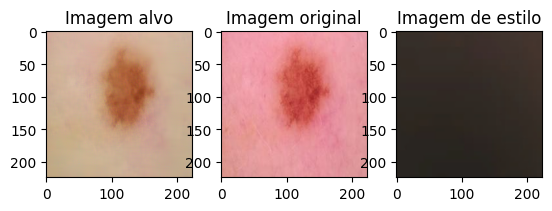

ÉPOCA 0501/3000 | perda conteúdo: 1.249 | perda estilo: 8.196 | perda TOTAL: 8196356.0
ÉPOCA 0502/3000 | perda conteúdo: 1.250 | perda estilo: 8.186 | perda TOTAL: 8185926.5
ÉPOCA 0503/3000 | perda conteúdo: 1.250 | perda estilo: 8.176 | perda TOTAL: 8175554.0
ÉPOCA 0504/3000 | perda conteúdo: 1.251 | perda estilo: 8.165 | perda TOTAL: 8165233.0
ÉPOCA 0505/3000 | perda conteúdo: 1.252 | perda estilo: 8.155 | perda TOTAL: 8154957.5
ÉPOCA 0506/3000 | perda conteúdo: 1.252 | perda estilo: 8.145 | perda TOTAL: 8144726.5
ÉPOCA 0507/3000 | perda conteúdo: 1.253 | perda estilo: 8.135 | perda TOTAL: 8134555.5
ÉPOCA 0508/3000 | perda conteúdo: 1.253 | perda estilo: 8.124 | perda TOTAL: 8124441.5
ÉPOCA 0509/3000 | perda conteúdo: 1.254 | perda estilo: 8.114 | perda TOTAL: 8114373.0
ÉPOCA 0510/3000 | perda conteúdo: 1.255 | perda estilo: 8.104 | perda TOTAL: 8104346.0
ÉPOCA 0511/3000 | perda conteúdo: 1.255 | perda estilo: 8.094 | perda TOTAL: 8094377.0
ÉPOCA 0512/3000 | perda conteúdo: 1.256 | p

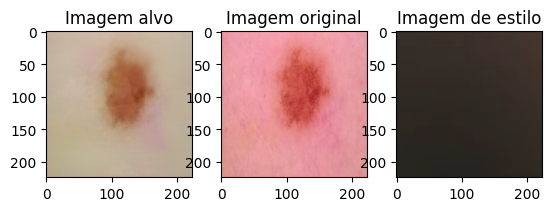

ÉPOCA 1001/3000 | perda conteúdo: 1.430 | perda estilo: 5.957 | perda TOTAL: 5957362.5
ÉPOCA 1002/3000 | perda conteúdo: 1.431 | perda estilo: 5.955 | perda TOTAL: 5955341.0
ÉPOCA 1003/3000 | perda conteúdo: 1.431 | perda estilo: 5.953 | perda TOTAL: 5953327.5
ÉPOCA 1004/3000 | perda conteúdo: 1.431 | perda estilo: 5.951 | perda TOTAL: 5951311.0
ÉPOCA 1005/3000 | perda conteúdo: 1.431 | perda estilo: 5.949 | perda TOTAL: 5949296.5
ÉPOCA 1006/3000 | perda conteúdo: 1.431 | perda estilo: 5.947 | perda TOTAL: 5947301.0
ÉPOCA 1007/3000 | perda conteúdo: 1.431 | perda estilo: 5.945 | perda TOTAL: 5945294.0
ÉPOCA 1008/3000 | perda conteúdo: 1.431 | perda estilo: 5.943 | perda TOTAL: 5943290.0
ÉPOCA 1009/3000 | perda conteúdo: 1.431 | perda estilo: 5.941 | perda TOTAL: 5941292.0
ÉPOCA 1010/3000 | perda conteúdo: 1.431 | perda estilo: 5.939 | perda TOTAL: 5939299.0
ÉPOCA 1011/3000 | perda conteúdo: 1.432 | perda estilo: 5.937 | perda TOTAL: 5937318.0
ÉPOCA 1012/3000 | perda conteúdo: 1.432 | p

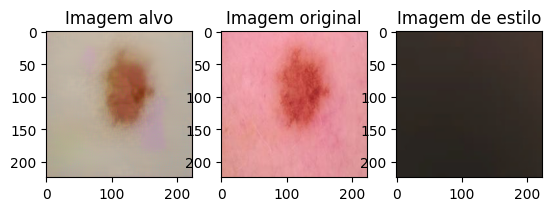

ÉPOCA 1501/3000 | perda conteúdo: 1.488 | perda estilo: 5.280 | perda TOTAL: 5280167.5
ÉPOCA 1502/3000 | perda conteúdo: 1.487 | perda estilo: 5.279 | perda TOTAL: 5279249.5
ÉPOCA 1503/3000 | perda conteúdo: 1.487 | perda estilo: 5.278 | perda TOTAL: 5278329.0
ÉPOCA 1504/3000 | perda conteúdo: 1.487 | perda estilo: 5.277 | perda TOTAL: 5277427.5
ÉPOCA 1505/3000 | perda conteúdo: 1.488 | perda estilo: 5.277 | perda TOTAL: 5276516.0
ÉPOCA 1506/3000 | perda conteúdo: 1.488 | perda estilo: 5.276 | perda TOTAL: 5275601.0
ÉPOCA 1507/3000 | perda conteúdo: 1.488 | perda estilo: 5.275 | perda TOTAL: 5274685.5
ÉPOCA 1508/3000 | perda conteúdo: 1.488 | perda estilo: 5.274 | perda TOTAL: 5273776.5
ÉPOCA 1509/3000 | perda conteúdo: 1.488 | perda estilo: 5.273 | perda TOTAL: 5272870.0
ÉPOCA 1510/3000 | perda conteúdo: 1.489 | perda estilo: 5.272 | perda TOTAL: 5271962.0
ÉPOCA 1511/3000 | perda conteúdo: 1.489 | perda estilo: 5.271 | perda TOTAL: 5271054.0
ÉPOCA 1512/3000 | perda conteúdo: 1.489 | p

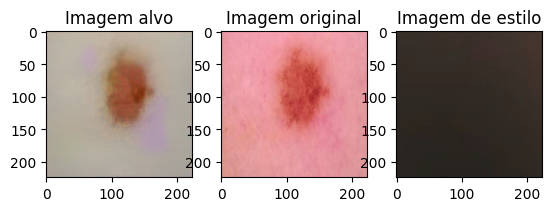

ÉPOCA 2001/3000 | perda conteúdo: 1.526 | perda estilo: 4.921 | perda TOTAL: 4920908.5
ÉPOCA 2002/3000 | perda conteúdo: 1.526 | perda estilo: 4.920 | perda TOTAL: 4920351.5
ÉPOCA 2003/3000 | perda conteúdo: 1.526 | perda estilo: 4.920 | perda TOTAL: 4919780.5
ÉPOCA 2004/3000 | perda conteúdo: 1.527 | perda estilo: 4.919 | perda TOTAL: 4919192.5
ÉPOCA 2005/3000 | perda conteúdo: 1.526 | perda estilo: 4.919 | perda TOTAL: 4918637.0
ÉPOCA 2006/3000 | perda conteúdo: 1.526 | perda estilo: 4.918 | perda TOTAL: 4918063.0
ÉPOCA 2007/3000 | perda conteúdo: 1.526 | perda estilo: 4.917 | perda TOTAL: 4917488.5
ÉPOCA 2008/3000 | perda conteúdo: 1.527 | perda estilo: 4.917 | perda TOTAL: 4916919.5
ÉPOCA 2009/3000 | perda conteúdo: 1.527 | perda estilo: 4.916 | perda TOTAL: 4916358.5
ÉPOCA 2010/3000 | perda conteúdo: 1.527 | perda estilo: 4.916 | perda TOTAL: 4915783.5
ÉPOCA 2011/3000 | perda conteúdo: 1.527 | perda estilo: 4.915 | perda TOTAL: 4915204.0
ÉPOCA 2012/3000 | perda conteúdo: 1.527 | p

In [ ]:
epochs = 3000
print_every = 500

start = datetime.now()
for epoch in range(epochs):

    target_img_features = extract_features(target_img)

    # Perda ao conteúdo
    target_img_content_features = target_img_features[21]
    new_img_content_features = new_img_features[21]
    content_loss = mse_loss(target_img_content_features, new_img_content_features)

    # Perda ao estilo
    style_loss = 0
    for layer in style_weights:
        target_img_feature = target_img_features[layer]
        _, c, h, w = target_img_feature.shape
        target_img_gram = gram_matrix(target_img_feature)
        style_img_gram = style_img_grams[layer]
        layer_loss = style_weights[layer] * mse_loss(target_img_gram, style_img_gram)
        layer_loss /= c * h * w
        style_loss += layer_loss

    # Perda total
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    print('ÉPOCA {:04d}/{} | perda conteúdo: {:3.3f} | perda estilo: {:3.3f} | perda TOTAL: {}'.format(epoch + 1,
                                                                                    epochs,
                                                                                    content_loss.item(),
                                                                                    style_loss.item(),
                                                                                    total_loss.item()))

    if (epoch + 1) % print_every == 0:
        print('Perda total:', total_loss.item())
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(show_img(target_img))
        ax1.set_title('Imagem alvo')
        ax2.imshow(show_img(new_img))
        ax2.set_title('Imagem original')
        ax3.imshow(show_img(style_img))
        ax3.set_title('Imagem de estilo')
        plt.show()

end = datetime.now()

print('Processo demorou {}'.format(end - start))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 8))
ax1.imshow(show_img(target_img))
ax1.set_title('Imagem alvo')
ax2.imshow(show_img(new_img))
ax2.set_title('Imagem original')
ax3.imshow(show_img(style_img))
ax3.set_title('Imagem de estilo')